# Lab Report 3:  Clustering

Name: Leong Teng Man

ID: SD20019

### References:

1. https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb
2. https://github.com/sharmaroshan/MNIST-Using-K-means/blob/master/KMeans%20Clustering%20for%20Imagery%20Analysis%20(Jupyter%20Notebook).ipynb
3. https://pair-code.github.io/understanding-umap/
4. https://umap-learn.readthedocs.io/en/latest/clustering.html

### Dataset context:
Mnist dataset contains train digit images, train labels, test digits and test labels. The digit images are grayscaled and 28*28 pixels. Its problem is to classify the digit from provided images.

### Dataset source:
1. [yann.lecun (raw compressed)](https://yann.lecun.com/exdb/mnist/)
2. [tensorflow mnist](https://www.tensorflow.org/datasets/catalog/mnist)

**Note**

The mnist dataset would be too big if in form of raw csv, hence readers please load it from provided `mnist.py`

### Instruction of loading dataset:
1. Put the `mnist.py` in the same directory as this notebook
2. That's it ;)

### Follow clustering process for K-Means and DBSCAN

Each digit of mnist is 28*28 pixels, then it is truncated and resized to smaller image for faster computation without losing too much information. Then, it is flattend to 1D array and scaled.

UMAP stands for uniform manifold approximation and projection; it reduces the dimensionality of input features. It is used for visualization and clustering process in DBSCAN. 

As DBSCAN and UMAP take time to calculate, their values will be cahced once called. With the same reason, only part of data is used for DBSCAN.

In earlier experimentation, DBSCAN doesn't work very well on origianl data. Then, UMAP is applied to reduce the dimension then DBSCAN clusters the reduced dataset rather the full dataset as in k-means. 

### Finally, compare your output based on these two different algorithms.

K-mean with 216 clusters accurately identifies 90% digits of validation dataset though it is **UNSUPERVISED** while having 81% homogeneity score. As shown in the plots, k-means able to identify the underlying structure of mnist dataset. 

K-mean can be useful to label a larger unlabelled dataset from clustering smaller labelled dataset.

The resultant DBSCAN identifies 13 clusters. DBSCAN accuracy is ceiled at 10% (almost useless; worse than random guessing) but its homogeneity score is up to 91%. As shown in the plots, DBSCAN is able to cluster mnist dataset when dimension is reduced. If applied to original dataset as in k-means, DBSCAN doesn't identify.

The high homogeneity score too can be implied from the confusion matrix where most of the points are culminated at few blocks of matrix.

In [82]:
#Import Libraries
import math
import mnist

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pip install umap-learn
import umap.umap_ as umap # dimension reduction
import tensorflow as tf # image processing

import sklearn as sk
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

mnist.download()
np.random.seed(42)

In [83]:
def unpad(arr, width):
    return arr[width:arr.shape[0]-width, width:arr.shape[1]-width]

def flatten_dim(dim):
    from operator import mul
    from functools import reduce
    return reduce(mul, dim)

def transform(digits, pad = None, dim = None):
    tmp = digits
    if pad is not None:
        tmp = np.array([unpad(img, pad) for img in tmp])
    if dim is not None:
        tmp = tf.constant(tmp)
        tmp = tf.image.resize(tmp, dim).numpy()
    tmp = tmp.reshape(-1, flatten_dim(tmp.shape[1:]))
    # the digit images are grayscale ranging 0 to 255 hence
    tmp = tmp / 255.0
    return tmp

def calc_all_metrics(X, true_label, pred_labels):
    from sklearn import metrics
    return {
        'homogeneity': metrics.homogeneity_score(true_label, pred_labels),
        'adjusted_rand': metrics.adjusted_rand_score(true_label, pred_labels),
        'accuracy' : metrics.accuracy_score(true_label, pred_labels),
    }

C:\Users\LEONGT~1\AppData\Local\Temp/ipykernel_16292/557602354.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


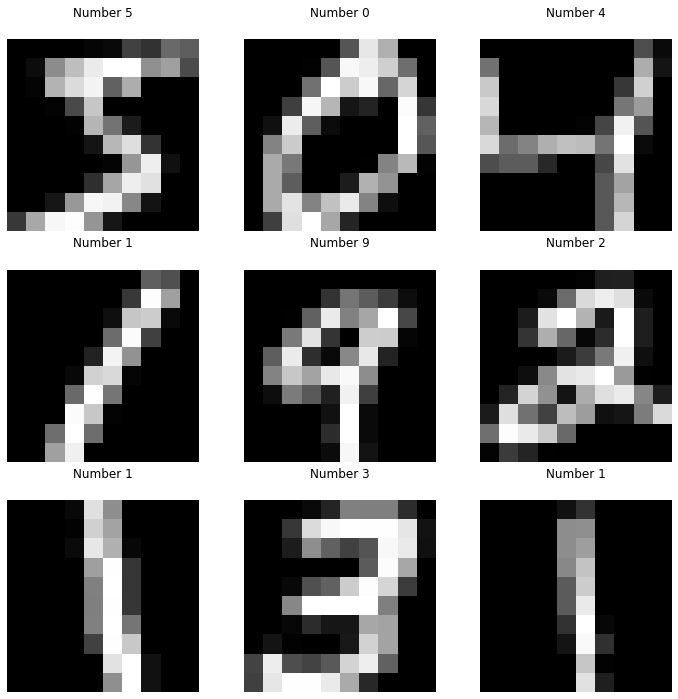

In [84]:
d = 10
digits, labels = mnist.extract_train()
test_digits, test_labels = mnist.extract_test()
digits, test_digits = tuple(transform(tmp, 4, (d,d)) for tmp in [digits, test_digits])
[tmp.shape for tmp in [digits, test_digits]]

fig, axs = plt.subplots(3, 3, figsize = (12,12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(digits[i].reshape(d,d))
    ax.axis('off')
    ax.set_title(f'Number {labels[i]}')

fig.show()

In [85]:
def fitting_umap(retrain=False):
    import os
    import joblib
    def train():
        umap_inst = umap.UMAP(
            n_neighbors=30,
            min_dist=0.0,
            n_components=2,
            random_state=42,
        ) # clusterable embedding
        standard_embedding = umap_inst.fit_transform(digits)
        joblib.dump(standard_embedding, 'standard_embedding.joblib')
        test_embedding = umap_inst.transform(test_digits)
        joblib.dump(test_embedding, 'test_embedding.joblib')

    if retrain == True:
        train()
    elif not set(['standard_embedding.joblib', 'test_embedding.joblib']) < set(os.listdir()):
        train()
    
    standard_embedding = joblib.load('standard_embedding.joblib')
    test_embedding = joblib.load('test_embedding.joblib')

    return standard_embedding, test_embedding

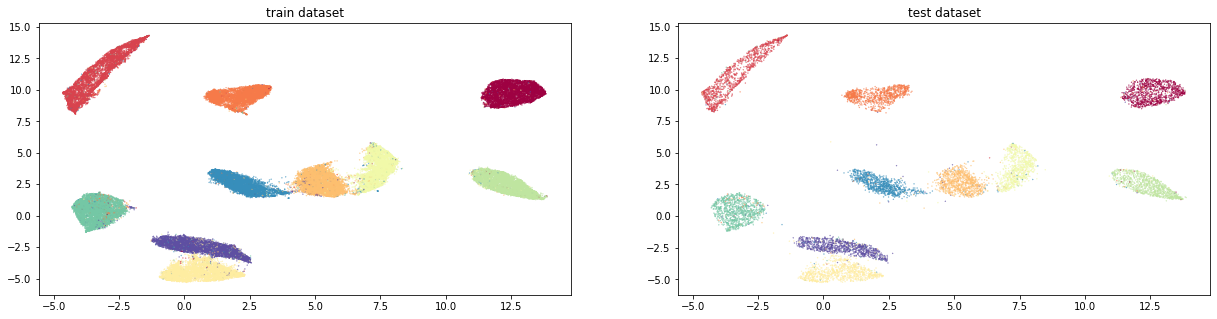

In [86]:
standard_embedding, test_embedding = fitting_umap()
fig, axs = plt.subplots(1,2, figsize = (21,5))

axs[0].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels.astype(int), s=0.1, cmap='Spectral')
axs[0].set_title('train dataset')
axs[1].scatter(test_embedding[:, 0], test_embedding[:, 1], c=test_labels.astype(int), s=0.1, cmap='Spectral')
axs[1].set_title('test dataset');

In [87]:
print(n_digits := len(np.unique(labels)))
kmeans = MiniBatchKMeans(n_clusters=n_digits)
kmeans.fit(digits), kmeans.labels_

10


(MiniBatchKMeans(n_clusters=10), array([4, 3, 0, ..., 8, 1, 6]))

In [88]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # extract points that correspond to label == i
        labels = []
        index = np.where(kmeans.labels_ == i)
        
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1: # why?
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

    return inferred_labels


def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [89]:
def calculate_metrics(X, Y, clusters):
    from sklearn.metrics import homogeneity_score, accuracy_score
    inertia_res, homogeneity_res, acc_res = [],[],[]
    
    for n_clusters in clusters:
        estimator = MiniBatchKMeans(n_clusters = n_clusters).fit(X)
    
        inertia_res.append(estimator.inertia_)    
        homogeneity_res.append(homogeneity_score(labels, estimator.labels_))
        
        # determine predicted labels
        cluster_labels = infer_cluster_labels(estimator, Y)
        predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
        
        acc_res.append(accuracy_score(Y, predicted_Y))
    return inertia_res, homogeneity_res, acc_res

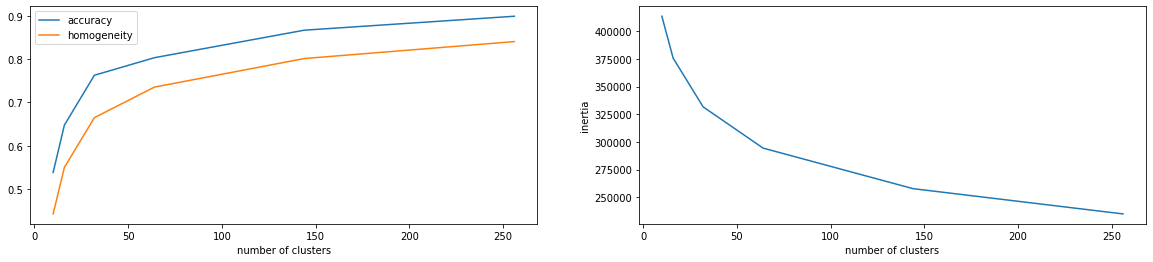

In [90]:
clusters = [10, 16, 32, 64, 144, 256]
inertia_res, homogeneity_res, acc_res = calculate_metrics(digits, labels, clusters)

fig, axs = plt.subplots(1, 2, figsize = (20,4))

axs[0].plot(clusters, acc_res, label = 'accuracy')
axs[0].plot(clusters, homogeneity_res, label = 'homogeneity')
axs[0].legend()
axs[0].set_xlabel("number of clusters")

axs[1].plot(clusters, inertia_res)
axs[1].set_ylabel("inertia")
axs[1].set_xlabel("number of clusters");

In [91]:
from sklearn import metrics
# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(digits)
cluster_labels = infer_cluster_labels(kmeans, labels)

# predict labels for testing data
test_clusters = kmeans.predict(test_digits)
predicted_labels = infer_data_labels(test_clusters, cluster_labels)
    
# calculate and print accuracy
{
    'train': metrics.accuracy_score(labels, infer_data_labels(kmeans.predict(digits), cluster_labels)),
    'validation': metrics.accuracy_score(test_labels, predicted_labels)
}

{'train': 0.8969333333333334, 'validation': 0.9026}

{'homogeneity': 0.7996909912428002,
 'adjusted_rand': 0.7958500737869081,
 'accuracy': 0.8969333333333334}

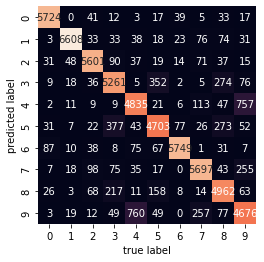

In [92]:
def plot_confusion_matrix(labels, pred_labels):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(labels, pred_labels)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

train_cluster = kmeans.predict(digits)
pred_labels = infer_data_labels(train_cluster, cluster_labels)
plot_confusion_matrix(labels, pred_labels)
calc_all_metrics(digits, labels, pred_labels)

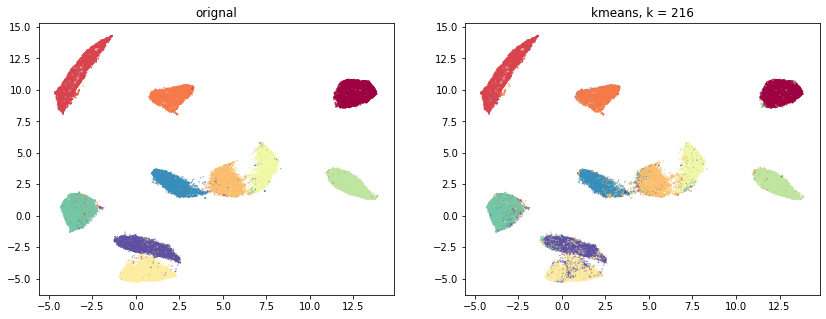

In [93]:
fig, axs = plt.subplots(1,2, figsize = (14,5))

axs[0].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels.astype(int), s=0.1, cmap='Spectral')
axs[0].set_title('orignal')
axs[1].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=pred_labels.astype(int), s=0.1, cmap='Spectral')
axs[1].set_title('kmeans, k = 216');

{'homogeneity': 0.8106215602591117,
 'adjusted_rand': 0.8065213993152061,
 'accuracy': 0.9026}

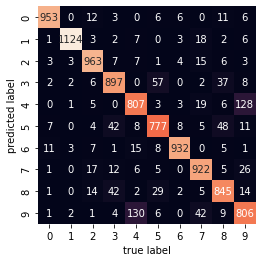

In [94]:
test_clusters = kmeans.predict(test_digits)
pred_labels = infer_data_labels(test_clusters, cluster_labels)
plot_confusion_matrix(test_labels, pred_labels)
calc_all_metrics(test_digits, test_labels, pred_labels)

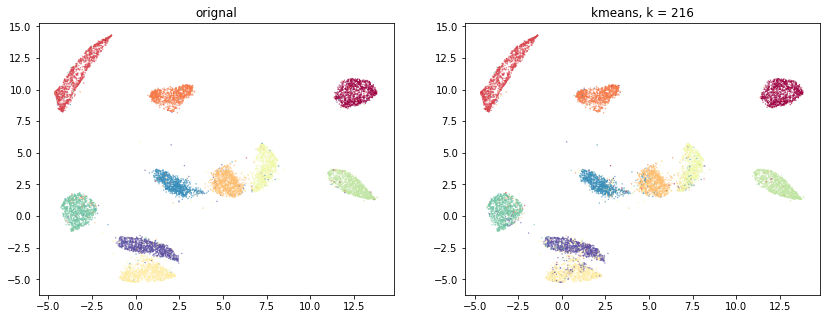

In [95]:
fig, axs = plt.subplots(1,2, figsize = (14,5))
axs[0].scatter(test_embedding[:, 0], test_embedding[:, 1], c=test_labels.astype(int), s=0.1, cmap='Spectral')
axs[0].set_title('orignal')
axs[1].scatter(test_embedding[:, 0], test_embedding[:, 1], c=pred_labels.astype(int), s=0.1, cmap='Spectral')
axs[1].set_title('kmeans, k = 216');

In [96]:
rng = np.random.default_rng(42)
rand_idx = lambda sz: rng.choice(mnist.TRAIN_SIZE, size = sz,replace=False, shuffle=False)
idx = rand_idx(10000)

In [97]:
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler()
standard_embedding = scaler_train.fit_transform(standard_embedding)
X, y = standard_embedding[idx], labels[idx]

In [98]:
db = DBSCAN(eps=0.007).fit(X)

pred_y = db.labels_

n_clusters = len(set(pred_y).difference([-1]))
n_noise_ = len(np.where(pred_y == -1)[0])

n_clusters, n_noise_, calc_all_metrics(X, y, pred_y)

(13,
 98,
 {'homogeneity': 0.9171683843806974,
  'adjusted_rand': 0.9222600261278533,
  'accuracy': 0.0937})

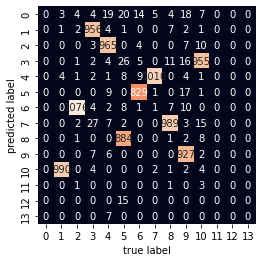

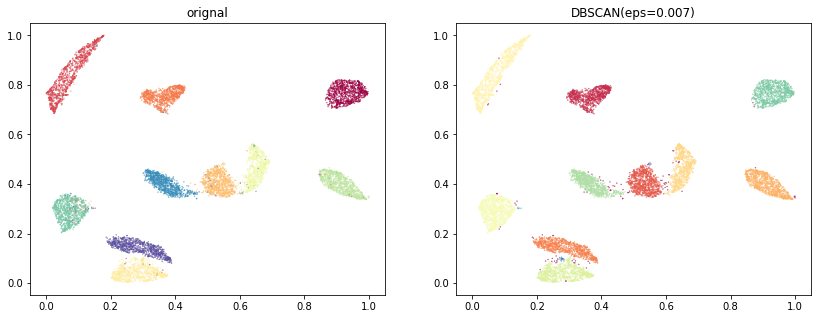

In [99]:
plot_confusion_matrix(y, pred_y)
fig, axs = plt.subplots(1,2, figsize = (14,5))
axs[0].scatter(X[:, 0], X[:, 1], c=y.astype(int), s=0.1, cmap='Spectral')
axs[0].set_title('orignal')
axs[1].scatter(X[:, 0], X[:, 1], c=pred_y.astype(int), s=0.1, cmap='Spectral')
axs[1].set_title(str(db));